In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [6]:
#load users data
users_title = ['UserID', 'Gender', 'Age', 'OccupationID', 'Zip-code']
users = pd.read_table('./ml-1m/users.dat', sep='::', header=None, names=users_title, engine = 'python')
users.head()

,UserID,Gender,Age,OccupationID,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [7]:
#load movies data
movies_title = ['MovieID', 'Title', 'Genres']
movies = pd.read_table('./ml-1m/movies.dat', sep='::', header=None, names=movies_title, engine = 'python', encoding='ISO-8859-1')
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
#load ratings data
ratings_title = ['UserID','MovieID', 'Rating', 'timestamps']
ratings = pd.read_table('./ml-1m/ratings.dat', sep='::', header=None, names=ratings_title, engine = 'python')
ratings.head()

,UserID,MovieID,Rating,timestamps
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [9]:
#split train-test set
train_ratings, validation_ratings = train_test_split(
    ratings, test_size=0.1, random_state=42
)

In [10]:
users_in_validation = validation_ratings["UserID"].unique()
all_users = users["UserID"].unique()

print(f"There are {len(users_in_validation)} users in validation set.")
print(f"Total number of users: {len(all_users)}")

There are 5970 users in validation set.
Total number of users: 6040


In [11]:
#build characteristics of the film
movie_index_by_id = {id: i for i, id in enumerate(movies["MovieID"])}
genres = [
    "Action",
    "Adventure",
    "Animation",
    "Children's",
    "Comedy",
    "Crime",
    "Documentary",
    "Drama",
    "Fantasy",
    "Film-Noir",
    "Horror",
    "Musical",
    "Mystery",
    "Romance",
    "Sci-Fi",
    "Thriller",
    "War",
    "Western",
]
genre_index_by_name = {name:i for i, name in enumerate(genres)}

# build binary array for movie genres
movie_features = np.zeros((len(movies), len(genres)))
for i, movie_genres in enumerate(movies["Genres"]):
    for genre in movie_genres.split("|"):        
        genre_index = genre_index_by_name[genre]
        movie_features[i, genre_index] = 1
print(movie_features)

[[0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


In [12]:
#train model for each users
def train_user_model(user_id):
    user_ratings = train_ratings[train_ratings["UserID"] == user_id]
    movie_indexes = [
        movie_index_by_id[movie_id] for movie_id in user_ratings["MovieID"]
    ]
    train_data = movie_features[movie_indexes]
    train_label = user_ratings["Rating"]
    model = Ridge(alpha=0.1)
    model.fit(train_data, train_label)
    return model


# build model for each user
user_model_dict = {}
for user_id in users["UserID"].unique():
    user_model_dict[user_id] = train_user_model(user_id)
print(user_model_dict[1])

Ridge(alpha=0.1)


In [13]:
#predict user preferences for a movie, rating is between 1 and 5
def predict(user_id, movie_id):
    movie_feature = movie_features[movie_index_by_id[movie_id]].reshape((1, -1))
    pred = user_model_dict[user_id].predict(movie_feature)
    return min(max(pred, 1), 5)

In [14]:
#evaluate model by RMSE
def eval_rmse(ratings: pd.DataFrame) -> float:
    predictions = np.zeros(len(ratings))
    for index, row in enumerate(ratings.itertuples(index=False)):
        predictions[index] = predict(row[0], row[1])
    rmse = mean_squared_error(ratings["Rating"], predictions, squared=False)
    return rmse
    
print(f"RMSE train: {eval_rmse(train_ratings)}")
print(f"RMSE validation: {eval_rmse(validation_ratings)}")

RMSE train: 0.9298923151317949
RMSE validation: 1.0423634495127465


In [15]:
#coefficients of an user
user_id = 160
for genre, coef in zip(genres, user_model_dict[user_id].coef_):
    print("{:15s}: {:.3f}".format(genre, coef))

Action         : -0.308
Adventure      : 0.710
Animation      : 0.198
Children's     : -0.199
Comedy         : -0.712
Crime          : 0.332
Documentary    : 0.000
Drama          : 0.225
Fantasy        : -0.396
Film-Noir      : 0.000
Horror         : 0.050
Musical        : 0.198
Mystery        : 0.000
Romance        : 0.771
Sci-Fi         : -0.373
Thriller       : -0.838
War            : -1.439
Western        : 0.000


In [19]:
#save model
from joblib import dump
dump(user_model_dict, './model/movie-recommendation/content-based.joblib')

['./model/movie-recommendation/content-based.joblib']

In [33]:
import matplotlib.pyplot as plt

#visualize test result
# actual = np.zeros(len(validation_ratings))
# predictions = np.zeros(len(validation_ratings))
actual = np.zeros(100)
predictions = np.zeros(100)
def get_data_for_visualize():
    for index, row in enumerate(validation_ratings.itertuples(index=False)):
        if index >= 100:
            break
        predictions[index] = predict(row[0], row[1])
        actual[index] = row[2]
    
get_data_for_visualize()

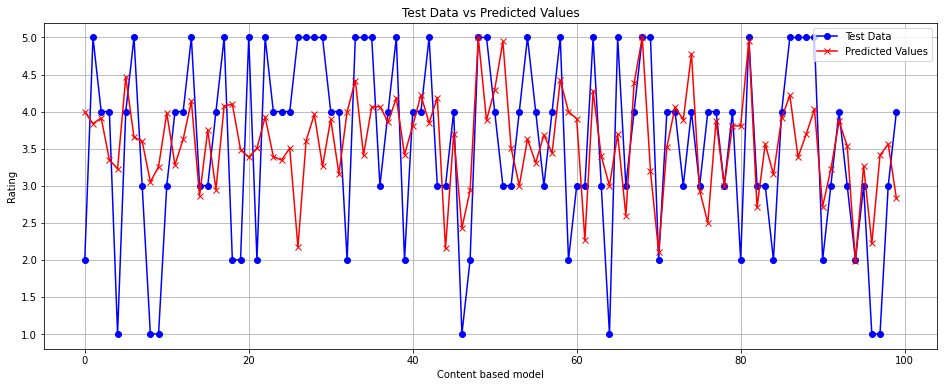

In [38]:
# x_point = range(0, len(validation_ratings))
x_point = range(0, 100)
plt.figure(figsize=(16, 6))
# Plotting test data
plt.plot(x_point, actual, marker='o', color='blue', label='Test Data')  # Plotting test data as a straight line (for example purposes)

# Plotting predicted values
plt.plot(x_point, predictions, marker='x', color='red', label='Predicted Values')
plt.xlabel('Content based model')
plt.ylabel('Rating')
plt.title('Test Data vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()